# Biometrics

Link to download dataset: https://disk.yandex.ru/d/lyhtieYbxQOYqw

In [ ]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio.transforms as T
import torch.optim as optim
import torch.utils.data as torch_data
import torchaudio
import tqdm.notebook as tqdm
import urllib
#from adan_pytorch import Adan
import random
import dataset

from IPython.display import clear_output

%matplotlib inline

In [ ]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/lyhtieYbxQOYqw'
final_url = base_url + urllib.parse.urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']
!wget -O voxceleb.tar.gz "{download_url}"
!tar -xf voxceleb.tar.gz

--2024-10-03 16:04:06--  https://downloader.disk.yandex.ru/disk/5bb3bed96b4dc9c40129babdaa0fe91b172b5cf2a1541048facf33f9fe03dbdb/66fef8b6/gtj3WQiuHGabqHv6W0pVHGRnXFJAW27izLLMm2MbHXViekKTxmGtGgT-Cdced2Nyo5eSrwwUCF_GbUu7CV3RNA%3D%3D?uid=0&filename=voxceleb.tar.gz&disposition=attachment&hash=UbepA8Q9HDxeFKWCa8Y0tO7K9asCmTAjTZtG1dex6z7oEbCbmS7yu53hGphcr8rhq/J6bpmRyOJonT3VoXnDag%3D%3D%3A&limit=0&content_type=application%2Fx-gzip&owner_uid=163052607&fsize=7150565898&hid=d5bd9cc88bda4eba5b285b6d33a11c38&media_type=compressed&tknv=v2
Resolving downloader.disk.yandex.ru (downloader.disk.yandex.ru)... 77.88.21.127, 2a02:6b8::2:127
Connecting to downloader.disk.yandex.ru (downloader.disk.yandex.ru)|77.88.21.127|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://s293vlx.storage.yandex.net/rdisk/5bb3bed96b4dc9c40129babdaa0fe91b172b5cf2a1541048facf33f9fe03dbdb/66fef8b6/gtj3WQiuHGabqHv6W0pVHGRnXFJAW27izLLMm2MbHXViekKTxmGtGgT-Cdced2Nyo5eSrwwUCF_GbUu7CV3RNA==?uid=0&f

### Some model train example

In [ ]:
DEVICE = 'cuda'
DATADIR = ''
FEATS = 80
LOADER_WORKERS = 8

In [ ]:
class Dataset(torch_data.Dataset):
    def __init__(self, datadir: str, feats: nn.Module):
        self._pathes = []
        self._speakers = []
        self._feats = feats
        speakers = os.listdir(datadir)
        for idx, speaker in enumerate(speakers):
            sp_dir = os.path.join(datadir, speaker)
            for item in os.listdir(sp_dir):
                self._pathes.append(os.path.join(sp_dir, item))
                self._speakers.append(idx)

        self.time_masking = T.TimeMasking(time_mask_param=80)
        self.freq_masking = T.FrequencyMasking(freq_mask_param=15)

    def plot_spectrogram(self, index):
        waveform, sample_rate = torchaudio.load(self._pathes[index])
        mel_spectrogram = T.MelSpectrogram(
            sample_rate=sample_rate,
            n_mels=128,
            n_fft=1024,
            hop_length=512
        )
        mel_spec = np.log10(mel_spectrogram(waveform) + 1e-10)
        mel_spec = self.time_masking(mel_spec)
        mel_spec = self.freq_masking(mel_spec)
        mel_spec_db = T.AmplitudeToDB()(mel_spec)

        plt.figure(figsize=(10, 4))
        plt.imshow(mel_spec_db[0].numpy(), cmap='viridis', aspect='auto', origin='lower')
        plt.colorbar(format='%+2.0f dB')
        plt.title('Mel Spectrogram')
        plt.xlabel('Time')
        plt.ylabel('Frequency')
        plt.show()

    def __getitem__(self, index):
        waveform, sample_rate = torchaudio.load(self._pathes[index])
        assert sample_rate == 16000
        assert waveform.shape[0] == 1


        spectrogram = np.log10(self._feats(waveform)[0] + 1e-10)

        masked_spectrogram = self.time_masking(spectrogram)
        masked_spectrogram = self.freq_masking(masked_spectrogram)


        prev, uttid = os.path.split(self._pathes[index])
        speaker_id = os.path.split(prev)[1]
        return (masked_spectrogram, self._speakers[index], os.path.join(speaker_id, uttid))

    def __len__(self) -> int:
        return len(self._pathes)

    def speakers(self) -> int:
        return self._speakers[-1] + 1


def collate_fn(batch) -> tuple[torch.Tensor, torch.Tensor, list[str]]:
    max_length = max(item[0].shape[1] for item in batch)
    X = torch.zeros((len(batch), batch[0][0].shape[0], max_length))
    for idx, item in enumerate(batch):
        X[idx, :, :item[0].shape[1]] = item[0]
    targets = torch.tensor([item[1] for item in batch], dtype=torch.long).reshape(len(batch), 1)
    pathes = [item[2] for item in batch]
    return (X, targets, pathes)


In [ ]:
transform = torchaudio.transforms.MelSpectrogram(n_mels=FEATS)
trainset = Dataset(os.path.join(DATADIR, 'voxceleb_train'), transform)
testset = Dataset(os.path.join(DATADIR, 'voxceleb_test'), transform)
test_targets = pd.read_csv(os.path.join(DATADIR, 'target.csv')).values.tolist()

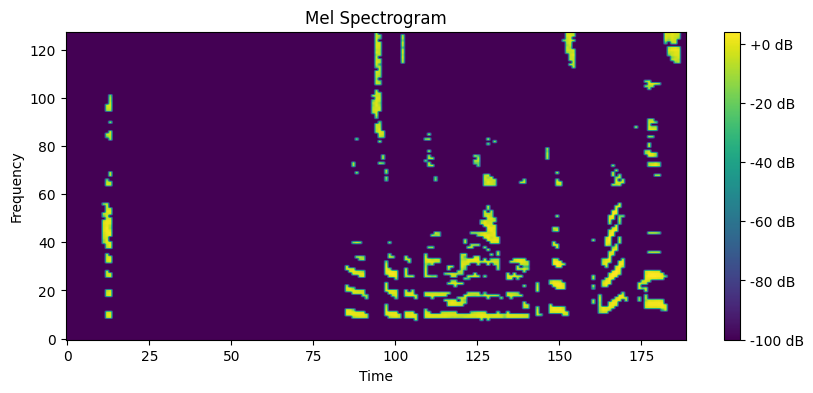

In [ ]:
trainset.plot_spectrogram(0)

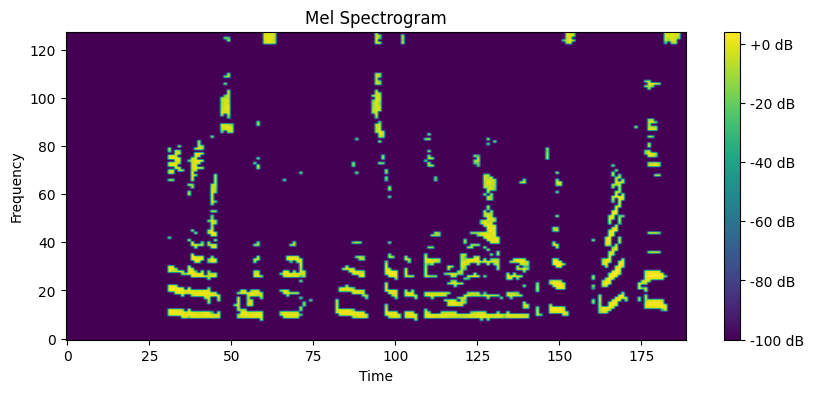

In [ ]:
trainset.plot_spectrogram(0)

### Models

In [ ]:
class Model(nn.Module):
    def __init__(self, input_shape: int, output_shape: int, hidden: int, kernel: int = 7, sride: int = 2):
        super().__init__()
        self._emb = nn.Sequential(
            nn.Conv1d(input_shape, hidden, kernel, stride=sride),
            nn.ReLU(),
            nn.Conv1d(hidden, hidden, kernel, stride=sride),
            nn.ReLU(),
            nn.Conv1d(hidden, hidden, kernel, stride=sride),
            nn.AdaptiveMaxPool1d(1),
        )
        self._final = nn.Conv1d(hidden, output_shape, 1)

    def forward(self, X) -> tuple[torch.Tensor, torch.Tensor]:
        emb = self._emb(X)
        return self._final(emb), emb

### Metrics

Cosine similarity:
$CS(a, b) = \frac{<a, b>}{\|a\| \|b\|}$

In [ ]:
def cosine_similarity(a, b):
    a = a.reshape(-1)
    b = b.reshape(-1)
    return np.dot(a, b) / np.linalg.norm(a) / np.linalg.norm(b)

Here is O(N log N) algorithm for find best_eer:
1) Sort prediction by probability
2) Going through items and recalculating far and frr

In [ ]:
def best_eer(data):
    full = sorted(data, key=lambda x: (x[0], -x[1]))
    pos = len([item for item in full if item[1] == 1])
    neg = len(full) - pos
    cur_pos = pos
    cur_neg = 0
    best_eer = 1
    for _, label in full:
        if label == 1:
            cur_pos -= 1
        else:
            cur_neg += 1
        cur_eer = max((pos - cur_pos) / pos, (neg - cur_neg) / neg)
        best_eer = min(best_eer, cur_eer)
    return best_eer

### Train

In [ ]:
def train_stage(model, opt, batch_size: int = 128):
    loader = torch_data.DataLoader(
        trainset,
        shuffle=True,
        batch_size=batch_size,
        collate_fn=dataset.collate_fn,
        num_workers=LOADER_WORKERS,
    )
    loss_sum = 0.0
    batches = 0
    for X, Y, _ in tqdm.tqdm(loader):
        Y = Y.squeeze(1)
        logits, _ = model.forward(X.to(DEVICE))
        loss = F.cross_entropy(logits, Y.to(DEVICE))
        loss_sum += loss.item()
        batches += 1
        opt.zero_grad()
        loss.backward()
        opt.step()
    return loss_sum / batches

In [ ]:
def calc_eval_score(model: nn.Module, batch_size: int = 128):
    loader = torch_data.DataLoader(
        testset,
        batch_size=batch_size,
        collate_fn=dataset.collate_fn,
        num_workers=LOADER_WORKERS,
    )
    items = {}
    target_scores = []
    with torch.no_grad():
        for X, _, pathes in tqdm.tqdm(loader):
            _, embds = model.forward(X.to(DEVICE))
            embds = embds.cpu().data.numpy().reshape(X.shape[0], -1)
            for embd, path in zip(embds, pathes):
                items[path] = embd
    for item1, item2, target in test_targets:
        target_scores.append((cosine_similarity(items[item1], items[item2]), target))
    return best_eer(target_scores)

In [ ]:
def train(
    model: nn.Module,
    batch_size: int = 128,
    epochs: int = 20,
):
    opt = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-8, weight_decay=0.0001)

    train_losses = []
    eval_scores = []
    for epoch in range(epochs):
        model.train()
        train_losses.append(train_stage(model, opt, batch_size=batch_size))
        model.eval()
        eval_scores.append(calc_eval_score(model, batch_size=batch_size))
        if eval_scores[-1] <= min(eval_scores):
            torch.save(model.state_dict(), 'ecapa15.pt')
        clear_output()
        fig, axis = plt.subplots(1, 2, figsize=(15, 7))
        axis[0].plot(np.arange(1, epoch + 2), train_losses, label='train CE loss')
        axis[1].plot(np.arange(1, epoch + 2), eval_scores, label='eval')
        axis[0].set(xlabel='epoch', ylabel='CE Loss')
        axis[1].set(xlabel='epoch', ylabel='EER')
        fig.legend()
        plt.show()
        print(f'Epoch {epoch + 1}. Train loss {train_losses[-1]}. Eval score {eval_scores[-1]}')

In [ ]:
model = Model(FEATS, trainset.speakers(), 128).to(DEVICE)
train(model)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


  0%|          | 0/530 [00:00<?, ?it/s]

KeyboardInterrupt: 

Best score is 30

### ECAPA TDNN

Paper: https://arxiv.org/pdf/2005.07143.pdf

Parts papers:
- SE-Blocks - https://arxiv.org/pdf/1709.01507.pdf
- Res2Net - https://arxiv.org/pdf/1904.01169.pdf
- Attentive Stats Pooling - https://arxiv.org/pdf/1803.10963.pdf
- AAM Softmax - https://arxiv.org/pdf/1906.07317.pdf

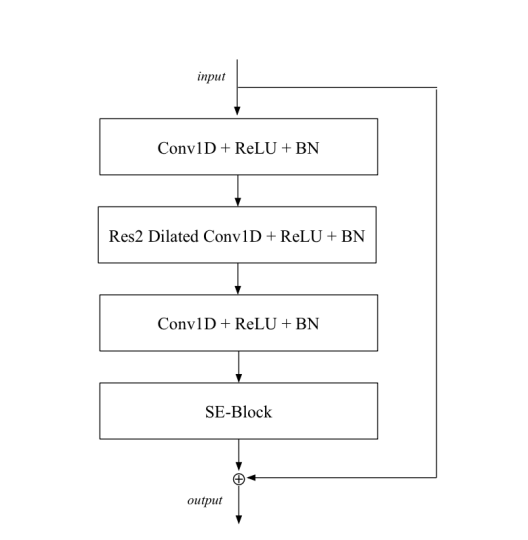

In [ ]:
class Res2DilatedConv1D(nn.Module):
    def __init__(self, kernel_size: int, dilation: int, C: int, scale: int, padding: int):
        super().__init__()
        self.k = kernel_size
        self.d = dilation
        self.scale = scale
        self.nums = scale
        self.width = C // scale
        self.p = padding

        self.convs = []
        self.bns = []
        for i in range(self.nums):
            self.convs.append(nn.Conv1d(self.width, self.width, self.k, dilation=self.d, padding=self.p))
            self.bns.append(nn.BatchNorm1d(self.width))

        self.convs = nn.ModuleList(self.convs)
        self.bns = nn.ModuleList(self.bns)

    def forward(self, X):
        outputs = []
        splits = torch.split(X, self.width, 1)
        for i in range(self.nums):
            if i == 0:
                split = splits[i]
            else:
                split += splits[i]

            split = self.convs[i](split)
            split = self.bns[i](F.relu(split))
            outputs.append(split)
        return torch.cat(outputs, dim=1)

In [ ]:
class SEBlock(nn.Module):
    def __init__(self, channels: int, s: int):
        super().__init__()
        self.linear1 = nn.Linear(channels, channels // s)
        self.linear2 = nn.Linear(channels // s, channels)

    def forward(self, X):
        output = torch.mean(X, dim=2)
        output = F.relu(self.linear1(output))
        output = torch.sigmoid(self.linear2(output))
        output = X * output.unsqueeze(2)
        return output

In [ ]:
class SERes2Block(nn.Module):
    def __init__(self, kernel_size: int, dilation: int, C: int, scale: int, padding: int):
        super().__init__()
        self.first_block = nn.Sequential(
            nn.Conv1d(C, C, kernel_size=1, padding=0),
            nn.ReLU(),
            nn.BatchNorm1d(C)
        )
        self.res2dilated_block = Res2DilatedConv1D(kernel_size, dilation, C, scale, padding)
        self.third_block = nn.Sequential(
            nn.Conv1d(C, C, kernel_size=1, padding=0),
            nn.ReLU(),
            nn.BatchNorm1d(C)
        )
        self.se_block = SEBlock(C, 2)

    def forward(self, X):
        X = self.first_block(X)
        X = self.res2dilated_block(X)
        X = self.third_block(X)
        X = self.se_block(X)
        return X


In [ ]:
class AttentiveStatPooling(nn.Module):
    def __init__(self, emb_size: int, hidden: int):
        super().__init__()
        self.emb_size = emb_size
        self.Q = nn.Conv1d(emb_size, hidden, kernel_size=1)
        self.K = nn.Conv1d(hidden, emb_size, kernel_size=1)

    def forward(self, X):
        out = torch.tanh(self.Q(X))
        attention_weights = torch.softmax(self.K(out), dim=-1)
        weighted_mean = torch.sum(attention_weights * X, dim=-1)
        weighted_std = torch.sqrt((torch.sum(attention_weights * X * X, dim=-1) - weighted_mean * weighted_mean).clamp(min=1e-9))
        return torch.cat([weighted_mean, weighted_std], dim=1)


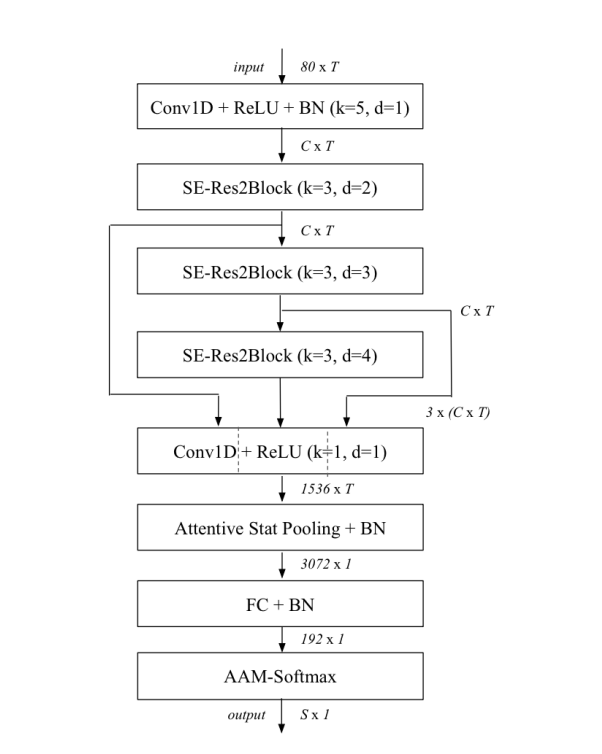

In [ ]:
class EcapaTDNN(nn.Module):
    def __init__(self, input_shape: int, output_shape: int, C: int):
        super().__init__()
        self.first_block = nn.Sequential(
            nn.Conv1d(input_shape, out_channels=C, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.BatchNorm1d(C),
        )
        self.second_block = SERes2Block(kernel_size=3, dilation=2, scale=8, padding=2, C=C)
        self.third_block = SERes2Block(kernel_size=3, dilation=3, scale=8, padding=3, C=C)
        self.fourth_block = SERes2Block(kernel_size=3, dilation=4, scale=8, padding=4, C=C)

        self.fifth_block = nn.Sequential(
            nn.Conv1d(C * 3, out_channels=1536, kernel_size=1),
            nn.ReLU()
        )

        self.attention_block = AttentiveStatPooling(emb_size=1536, hidden=128)
        self.bn1 = nn.BatchNorm1d(3072)

        self.linear = nn.Linear(3072, output_shape)
        self.bn2 = nn.BatchNorm1d(output_shape)

    def forward(self, X):

        out1 = self.first_block(X)
        out2 = self.second_block(out1) + out1
        out3 = self.third_block(out2) + out2 + out1
        out4 = self.fourth_block(out3) + out3 + out2 + out1

        out = torch.cat([out2, out3, out4], dim=1)
        out = self.fifth_block(out)

        emb = self.bn1(self.attention_block(out))
        out = self.bn2(self.linear(emb))
        return out, emb

In [ ]:
torch.cuda.empty_cache()
ecapa_model = EcapaTDNN(FEATS, trainset.speakers(), 512).to(DEVICE)

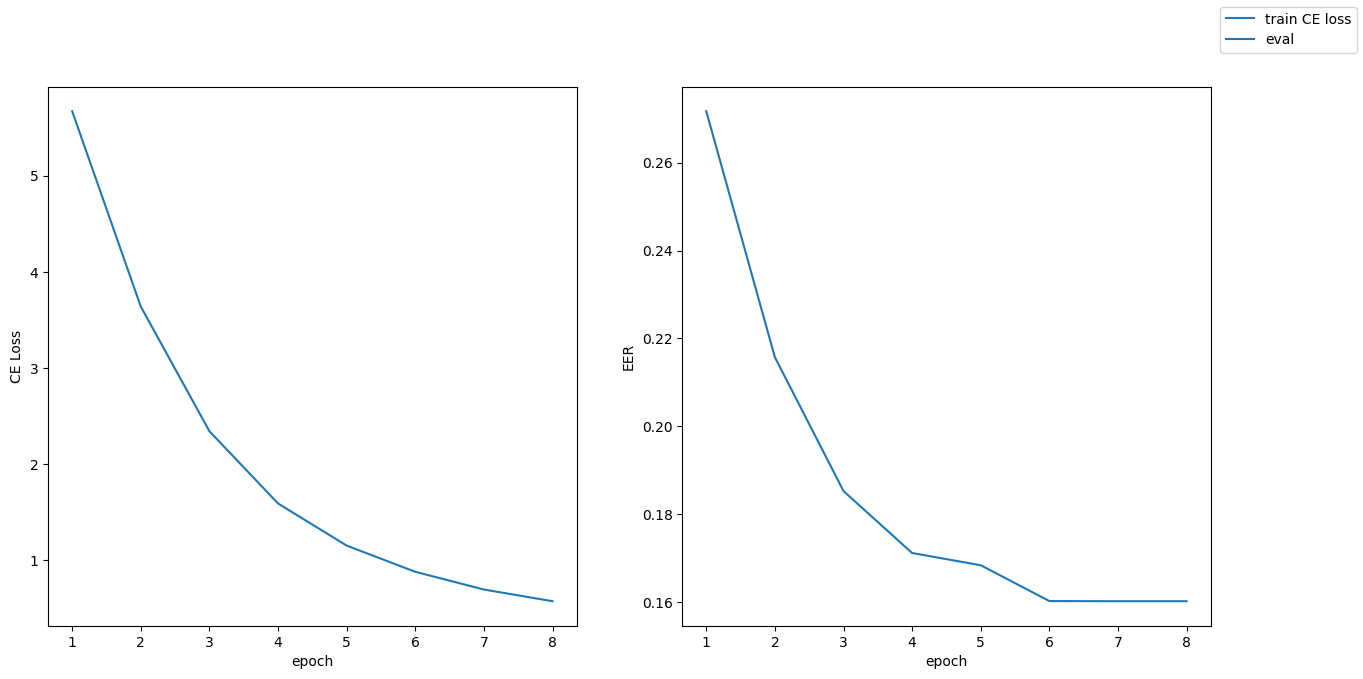

Epoch 8. Train loss 0.5736055351653189. Eval score 0.1602771949901456


  0%|          | 0/530 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
train(ecapa_model)
torch.cuda.empty_cache()

Best score is 15.0

In [ ]:
ecapa_model.eval()
loader = torch_data.DataLoader(
        testset,
        batch_size=64,
        collate_fn=dataset.collate_fn,
        num_workers=LOADER_WORKERS,
    )

embs_list = []
with torch.no_grad():
    for X, _, pathes in tqdm.tqdm(loader):
        _, embds = ecapa_model.forward(X.to(DEVICE))
        embds = embds.cpu().data.reshape(X.shape[0], -1)
        embds = torch.split(embds, 1)
        for embedding in embds:
            embs_list.append(embedding.squeeze().numpy())

  0%|          | 0/70 [00:00<?, ?it/s]

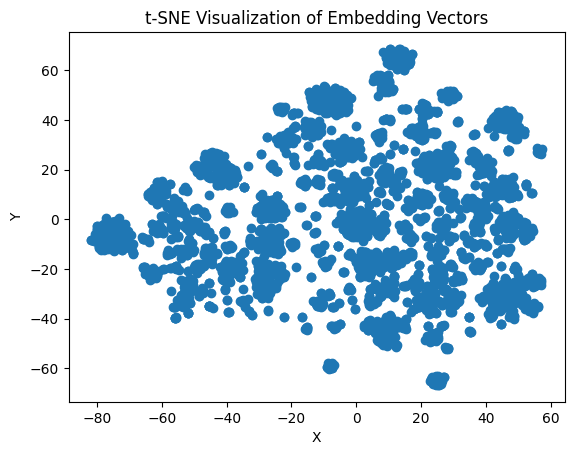

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=52)
embs = tsne.fit_transform(np.array(embs_list))
plt.scatter(embs[:, 0], embs[:, 1])
plt.title('t-SNE Visualization of Embedding Vectors')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In [ ]:
class TripletDataset(torch_data.Dataset):

    def __init__(self, datadir: str, feats: nn.Module):
        self._pathes = []
        self._speakers = []
        self._feats = feats
        speakers = os.listdir(datadir)
        for idx, speaker in enumerate(speakers):
            sp_dir = os.path.join(datadir, speaker)
            for item in os.listdir(sp_dir):
                self._pathes.append(os.path.join(sp_dir, item))
                self._speakers.append(idx)

        self.time_masking = T.TimeMasking(time_mask_param=80)
        self.freq_masking = T.FrequencyMasking(freq_mask_param=15)

    def __getitem__(self, index):

        anchor_path = self._pathes[index]
        waveform, sample_rate = torchaudio.load(anchor_path)
        assert sample_rate == 16000
        assert waveform.shape[0] == 1


        spectrogram = np.log10(self._feats(waveform)[0] + 1e-10)

        masked_spectrogram = self.time_masking(spectrogram)
        anchor_masked_spectrogram = self.freq_masking(masked_spectrogram)

        anchor_speaker_idx = self._speakers[index]
        anchor_speaker_dir, uttid = os.path.split(self._pathes[index])
        speaker_files = os.listdir(anchor_speaker_dir)
        positive_path = os.path.join(anchor_speaker_dir, np.random.choice(speaker_files))

        while positive_path == anchor_path:
            positive_path = os.path.join(anchor_speaker_dir, random.choice(speaker_files))

        pos_waveform, sample_rate = torchaudio.load(positive_path)
        pos_spectrogram = np.log10(self._feats(pos_waveform)[0] + 1e-10)
        masked_pos_spectrogram = self.time_masking(pos_spectrogram)
        pos_masked_spectrogram = self.freq_masking(masked_pos_spectrogram)


        negative_speaker_index = np.random.randint(0, len(self._pathes))
        while self._speakers[negative_speaker_index] == self._speakers[index]:
            negative_speaker_index = np.random.randint(0, len(self._pathes))

        neg_waveform, sample_rate = torchaudio.load(self._pathes[negative_speaker_index])
        neg_spectrogram = np.log10(self._feats(neg_waveform) + 1e-10)
        masked_neg_spectrogram = self.time_masking(neg_spectrogram)
        neg_masked_spectrogram = self.freq_masking(masked_neg_spectrogram)

        return anchor_masked_spectrogram, pos_masked_spectrogram, neg_masked_spectrogram.squeeze(0), int(anchor_speaker_idx)
        # prev, uttid = os.path.split(self._pathes[index])
        # speaker_id = os.path.split(prev)[1]
        # return (masked_spectrogram, self._speakers[index], os.path.join(speaker_id, uttid))

    def __len__(self) -> int:
        return len(self._pathes)

    def speakers(self) -> int:
        return self._speakers[-1] + 1


def triplet_collate_fn(batch) -> tuple[torch.Tensor, torch.Tensor, list[str]]:
    max_length = max(max([tensor.shape[1] for tensor in item if type(tensor) != int]) for item in batch)
    anchor = torch.zeros((len(batch), batch[0][0].shape[0], max_length))
    positive = torch.zeros((len(batch), batch[0][0].shape[0], max_length))
    negative = torch.zeros((len(batch), batch[0][0].shape[0], max_length))
    anchor_idx = torch.zeros(len(batch))
    for idx, item in enumerate(batch):
        anchor[idx, :, :item[0].shape[1]] = item[0]
        positive[idx, :, :item[1].shape[1]] = item[1]
        negative[idx, :, :item[2].shape[1]] = item[2]
        anchor_idx[idx] = item[3]
    return (anchor, positive, negative, anchor_idx)


In [ ]:
class TripletLoss(nn.Module):

    def __init__(self, margin=1.0):
        super().__init__()
        self._margin = margin

    def euclidean_distance(self, v1, v2):
        return torch.sum((v1 - v2) ** 2, axis=1)

    def forward(self, anchor, positive, negative):
        pos_dist = self.euclidean_distance(anchor, positive)
        neg_dist = self.euclidean_distance(anchor, negative)
        loss = F.relu(pos_dist - neg_dist + self._margin)
        return loss.mean()

In [ ]:
class MixedLoss(nn.Module):
    def __init__(self, margin=0.3, alpha=0.1):
        super().__init__()
        self._margin = margin
        self._alpha = alpha
        self.triplet = TripletLoss(margin)
        self.cross_entropy = nn.CrossEntropyLoss()

    def forward(self, anchor, positive, negative, y_true):
        return self.triplet(anchor, positive, negative) + self._alpha * self.cross_entropy(anchor, y_true.long())


##Train with TripletLoss

In [ ]:
triplet_trainset = TripletDataset(os.path.join(DATADIR, 'voxceleb_train'), transform)
criterion = MixedLoss()

In [ ]:
def triplet_train_stage(model, opt, batch_size: int = 128):
    loader = torch_data.DataLoader(
        triplet_trainset,
        shuffle=True,
        batch_size=batch_size,
        collate_fn=triplet_collate_fn,
        num_workers=LOADER_WORKERS,
    )
    loss_sum = 0.0
    batches = 0
    for anchor, positive, negative, y_true in tqdm.tqdm(loader):
        _, anchor_embs = model.forward(anchor.to(DEVICE))
        _, positive_embs = model.forward(positive.to(DEVICE))
        _, negative_embs = model.forward(negative.to(DEVICE))
        loss = criterion(anchor_embs, positive_embs, negative_embs, y_true.to(DEVICE))
        loss_sum += loss.item()
        batches += 1
        opt.zero_grad()
        loss.backward()
        opt.step()
    return loss_sum / batches

In [ ]:
def triplet_calc_eval_score(model: nn.Module, batch_size: int = 128):
    loader = torch_data.DataLoader(
        testset,
        batch_size=batch_size,
        collate_fn=dataset.collate_fn,
        num_workers=LOADER_WORKERS,
    )
    items = {}
    target_scores = []
    with torch.no_grad():
        for X, _, pathes in tqdm.tqdm(loader):
            _, embds = model.forward(X.to(DEVICE))
            embds = embds.cpu().data.numpy().reshape(X.shape[0], -1)
            for embd, path in zip(embds, pathes):
                items[path] = embd
    for item1, item2, target in test_targets:
        target_scores.append((cosine_similarity(items[item1], items[item2]), target))
    return best_eer(target_scores)

In [ ]:
def triplet_train(
    model: nn.Module,
    batch_size: int = 128,
    epochs: int = 20,
):
    opt = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-8, weight_decay=0.0001)

    train_losses = []
    eval_scores = []
    for epoch in range(epochs):
        model.train()
        train_losses.append(triplet_train_stage(model, opt, batch_size=batch_size))
        model.eval()
        eval_scores.append(triplet_calc_eval_score(model, batch_size=batch_size))
        if eval_scores[-1] <= min(eval_scores):
            torch.save(model.state_dict(), 'ecapa_triplet.pt')
        clear_output()
        fig, axis = plt.subplots(1, 2, figsize=(15, 7))
        axis[0].plot(np.arange(1, epoch + 2), train_losses, label='train CE loss')
        axis[1].plot(np.arange(1, epoch + 2), eval_scores, label='eval')
        axis[0].set(xlabel='epoch', ylabel='CE Loss')
        axis[1].set(xlabel='epoch', ylabel='EER')
        fig.legend()
        plt.show()
        print(f'Epoch {epoch + 1}. Train loss {train_losses[-1]}. Eval score {eval_scores[-1]}')

In [ ]:
ecapa_model.load_state_dict(torch.load('/content/ecapa15best.pt', weights_only=True))

<All keys matched successfully>

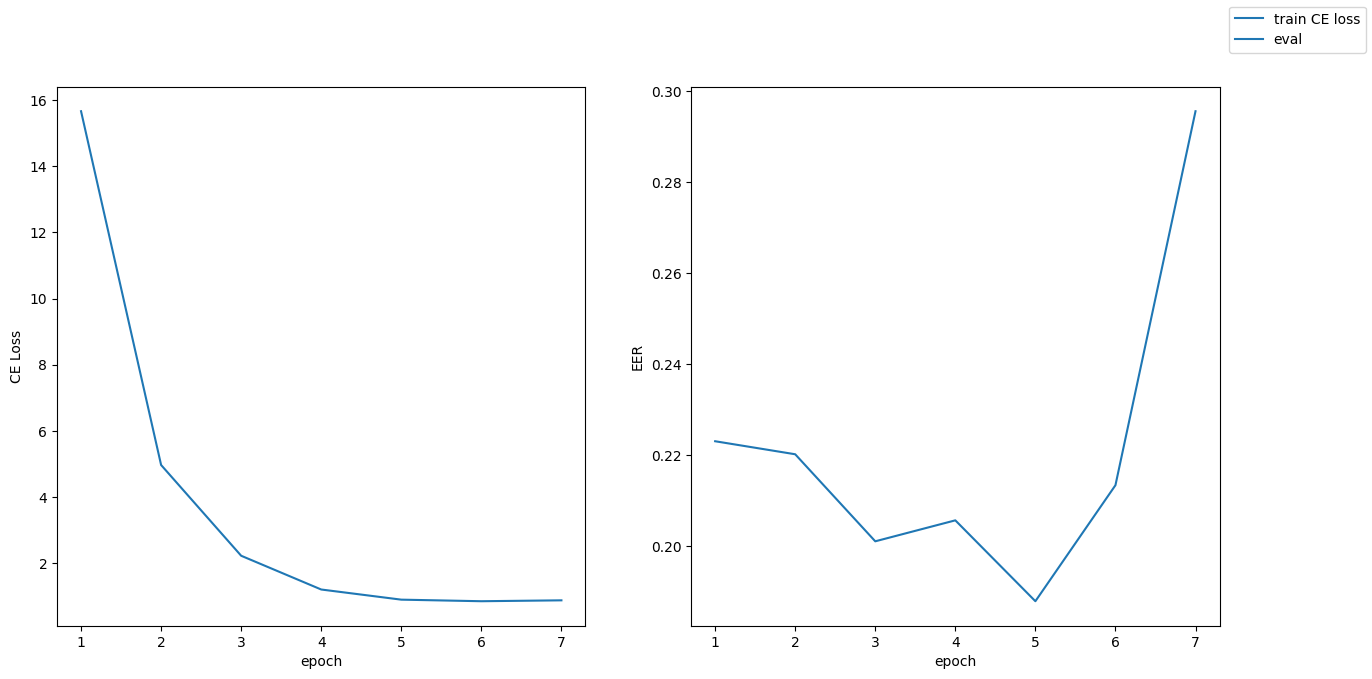

Epoch 7. Train loss 0.8690041645397945. Eval score 0.29549185503220105


  0%|          | 0/2119 [00:00<?, ?it/s]

In [ ]:
triplet_train(ecapa_model, 32, 50)

In [ ]:
torch.cuda.empty_cache()

In [ ]:
del trainset